# 2. Multi-instrument one-dimensional analysis

In the last notebook, we have extracted counts vs energy, but this is a physical quantity (or information) filtered through our detector system. What we really aim at estimating is the gamma-ray flux of the source. As we can measure the flux over a large band in energy, we usually measure the spectrum, the flux vs energy.

In [1]:
# - basic dependencies
import numpy as np
import astropy.units as u
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# - Gammapy dependencies
from gammapy.datasets import SpectrumDatasetOnOff, Datasets
from gammapy.modeling import Parameter
from gammapy.modeling.models import (
    SpectralModel,
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

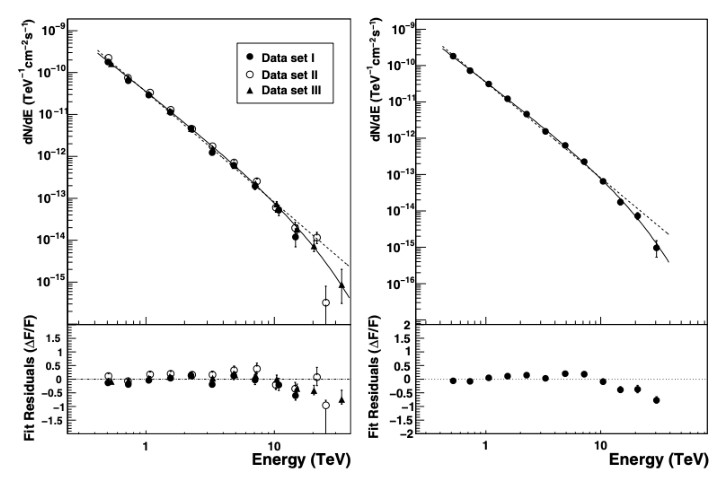

In [2]:
# read image
img = mpimg.imread("figures/crab_sed_hess.png")
# display image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)
ax.axis("off")
plt.show()

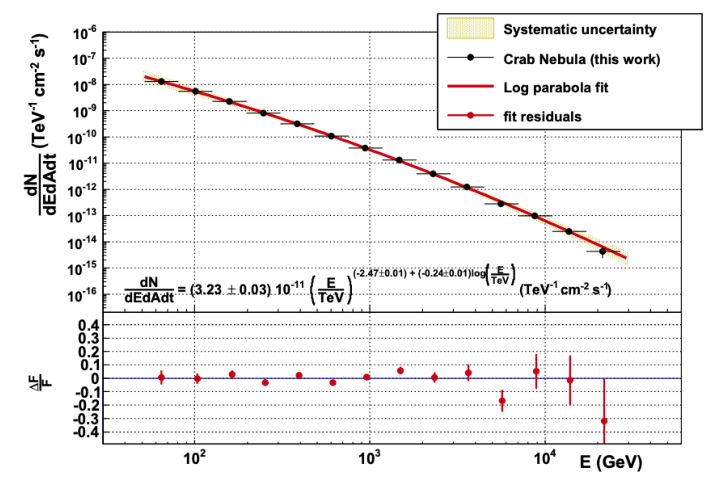

In [3]:
# read image
img = mpimg.imread("figures/crab_sed_magic.png")
# display image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)
ax.axis("off")
plt.show()

It is commonly assumed that a simple analytical function describes the gamma-ray (differential) flux vs energy. The most common example is a power-law (we will see in tomorrow's lecture where power-law of photons come from):

$$
\frac{{\rm d}\phi}{{\rm d}E}(E; \Phi_0, \Gamma, E_0)\,[{\rm TeV}^{-1}\,{\rm cm}^{-2}\,{\rm s}^{-1}] = 
\Phi_0 \left(\frac{E}{E_0}\right)^{-\Gamma}.
$$

Note that we have a continuous dependency on the energy (we want to measure the flux as a function of the energy) and we have a (parametric) dependency on few parameters that describe our analytical spectrum, in this case the normalisation $\Phi_0$, the reference energy, $E_0$, and the spectral index, $\Gamma$. From now on, we will represent all the model parameters with an array $\hat{\theta}$.

Let us now plot some of the examples of analytical spectra available in `Gammapy`:

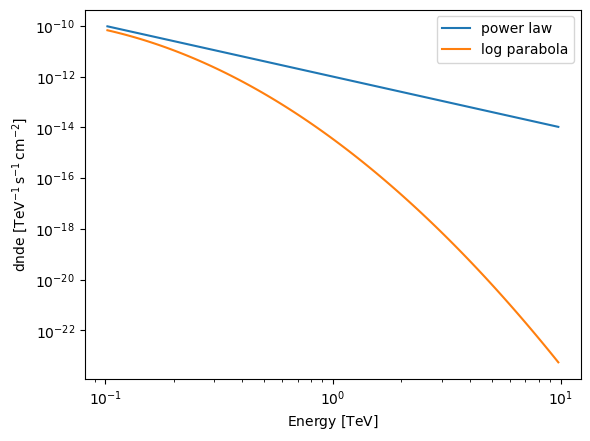

In [4]:
energy_bounds = [100 * u.GeV, 10 * u.TeV]
pwl = PowerLawSpectralModel()
pwl.plot(energy_bounds, label="power law")
lp = LogParabolaSpectralModel(
    amplitude=7e-11 * u.Unit("TeV-1 cm-2 s-1"), reference=100 * u.GeV
)
lp.plot(energy_bounds, label="log parabola")
plt.legend()
plt.show()

How can we adjust the parameters $\hat{\theta}$ of the analytical spectrum to the counts that we have extracted? That's where the IRF come into place. The IRF allow us to go from gamma-ray flux to instrument counts and vice versa. By folding (i.e. convolving) the analytical flux model with the response of the system we can obtain counts vs energy. We basically transform the absolute flux quantity relative to the detector. THe number of model (or _predicted_) counts in a given energy bin $\Delta E_{\rm est}$ is:

$$
g_{i}(\hat{\theta}) = 
    t_{\rm eff} \int_{\Delta E_{\rm est}} {\rm d}E_{\rm est} \int_{0}^{\infty} {\rm d}E_{\rm true}
    A_{\rm eff}(E_{\rm true}) M(E_{\rm est}|E_{\rm true}) \frac{{\rm d}\phi}{{\rm d}E}(E; \hat{\theta}),
$$

where $A_{\rm eff}(E_{\rm true})$ represent the effective area and $M(E_{\rm est}|E_{\rm true})$ the energy dispersion, i.e. the PDF of the energy estimator.

How we decide which (predicted) counts better describe our model? With a likelihood, we assume that the counts in each bin are described by Poissonian statistics. The total likelihood for our dataset, accounting for the observed and estimated counts in each energy bin, reads:

$$ 
\mathcal{L}(\hat{\theta}) = 
    \Pi_{i=1}^{N} {\rm Pois}(g_i(\hat{\theta}) + b_i; N_{{\rm ON}, i}) {\rm Pois}(b_i / \alpha; N_{{\rm OFF}, i})
$$

where $b_i$ is the number of predicted counts, $\alpha$ the ratio between the on and off region exposures. $b_i$ is typically treated as a nuisance parameter. The likelihood is maximised by varying the spectral parameters $\theta$, and hence the number of predicted counts.

## 2.1. Predicting the counts for a given data set
Let us load the data sets we created in the previous notebook.

In [5]:
# H.E.S.S. data sets
obs_ids_hess = [23523, 23526, 23559, 23592]
# declare the energy range to be used for the fitting
e_min_hess = 0.66 * u.TeV
e_max_hess = 30 * u.TeV

# load H.E.S.S. spectral datasets
datasets_hess = Datasets()
for obs_id in obs_ids_hess:
    dataset = SpectrumDatasetOnOff.read(f"results/spectra/hess/pha_obs_{obs_id}.fits")
    # set the proper energy ranges
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min_hess, e_max_hess)
    datasets_hess.append(dataset)


# MAGIC data sets
obs_ids_magic = [5029747, 5029748]
# declare the energy range to be used for the fitting
e_min_magic = 0.08 * u.TeV
e_max_magic = 10 * u.TeV

# load MAGIC spectral datasets
datasets_magic = Datasets()
for obs_id in obs_ids_magic:
    dataset = SpectrumDatasetOnOff.read(f"results/spectra/magic/pha_obs_{obs_id}.fits")
    # set the proper energy ranges
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min_magic, e_max_magic)
    datasets_magic.append(dataset)


# LST data sets
obs_ids_lst = [7253, 7254, 7255, 7256, 7274, 7275, 7276, 7277]
# declare the energy range to be used for the fitting
e_min_lst = 0.06 * u.TeV
e_max_lst = 30 * u.TeV

# load LST spectral datasets
datasets_lst = Datasets()
for obs_id in obs_ids_lst:
    dataset = SpectrumDatasetOnOff.read(f"results/spectra/lst/pha_obs_{obs_id}.fits")
    # set the proper energy ranges
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min_lst, e_max_lst)
    datasets_lst.append(dataset)

Once we have the data sets we can specify a model for them, `Gammapy` will automatically convolve it with the response of the system and compute (predict) the counts. Here an example.

In [6]:
# define the model to be fitted
spectral_model = LogParabolaSpectralModel(
    amplitude=5e-12 * u.Unit("TeV-1 cm-2 s-1"),
    reference=1 * u.TeV,
    alpha=2.3 * u.Unit(""),
    beta=0.1 * u.Unit(""),
)
# trick to facilitate ULs computation
spectral_model.amplitude.min = 1e-20
spectral_model.amplitude.max = 1e-5
print(spectral_model)

model = SkyModel(spectral_model=spectral_model, name="CrabNebula")

datasets_lst.models = [model]

LogParabolaSpectralModel

type    name     value         unit        error      min       max    frozen is_norm link prior
---- --------- ---------- -------------- --------- --------- --------- ------ ------- ---- -----
     amplitude 5.0000e-12 TeV-1 s-1 cm-2 0.000e+00 1.000e-20 1.000e-05  False    True           
     reference 1.0000e+00            TeV 0.000e+00       nan       nan   True   False           
         alpha 2.3000e+00                0.000e+00       nan       nan  False   False           
          beta 1.0000e-01                0.000e+00       nan       nan  False   False           


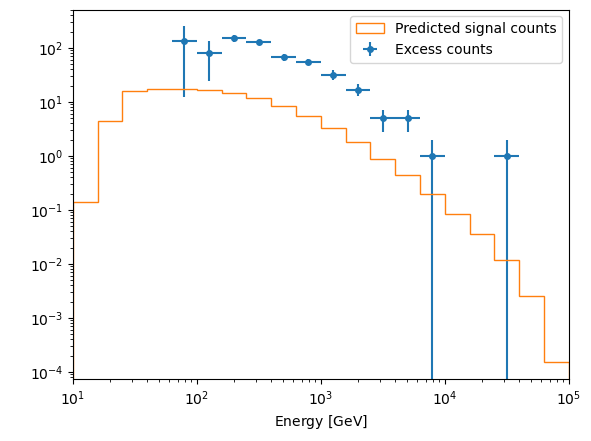

In [7]:
datasets_lst[0].plot_excess()
plt.show()

We can also check the contribution of this data set to the total likelihood.

In [8]:
datasets_lst[0].stat_sum()

238.15655654576287

As we can see, the counts predicted by the model we specified for the data set are one order of magnitude below the observed source counts. 

To get a feeling of how the fit work, let us go back to the definition of the spectral analytical function and change the amplitude parameter to `5e-11 * u.Unit("TeV-1 cm-2 s-1")`. What happens to the predicted counts? And what happens to the likelihood statistics?

In [9]:
datasets_lst.models[0].spectral_model.amplitude.value

5e-12

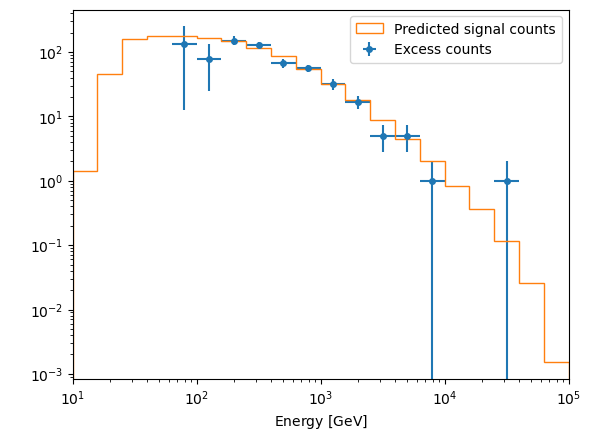

In [10]:
datasets_lst.models[0].spectral_model.amplitude.value = 5e-11

datasets_lst[0].plot_excess()
plt.show()

In [11]:
datasets_lst[0].stat_sum()

11.000246544592203


You have now an intuition of how the fitting routine work. The parameters will be changed until the best match between observed and predicted counts is observed. This agreement is statistically quantified by the likelihood, which is what is actually maximised.

## 2.2. Spectrum of the Crab Nebula as seen by the MAGIC telescopes
The likelihood maximisation is performed by the `gammapy.Fit` class suing the `gammapy.Dataset` and the model we have attached to it.

In [12]:
# run the fit!
fit = Fit()
results = fit.run(datasets=datasets_lst)
print(results)
print(spectral_model)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 63
	total stat : 119.19

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

LogParabolaSpectralModel

type    name     value         unit        error      min       max    frozen is_norm link prior
---- --------- ---------- -------------- --------- --------- --------- ------ ------- ---- -----
     amplitude 4.3462e-11 TeV-1 s-1 cm-2 1.559e-12 1.000e-20 1.000e-05  False    True           
     reference 1.0000e+00            TeV 0.000e+00       nan       nan   True   False           
         alpha 2.5138e+00                4.058e-02       nan       nan  False   False           
          beta 1.4152e-01                2.835e-02       nan       nan  False   False           


We can check, after the optimisation, how the predicted counts adapt to the observed one

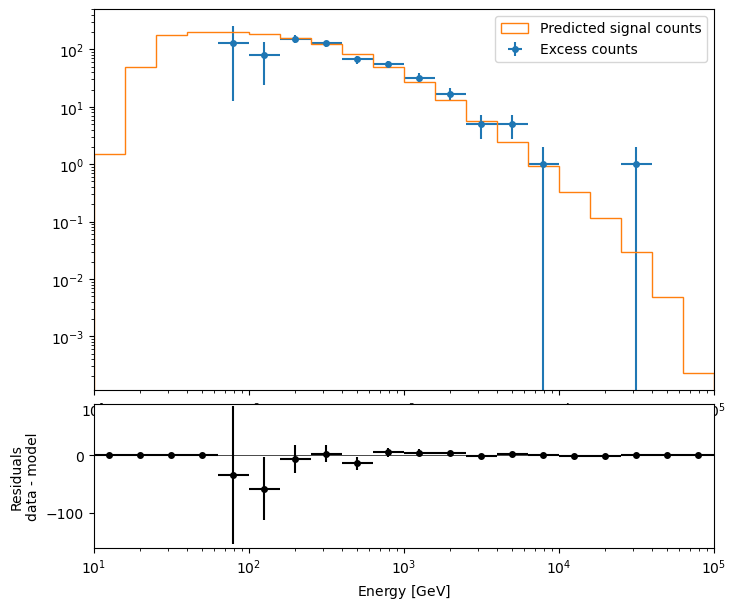

In [13]:
ax_spectrum, ax_residuals = datasets_lst[0].plot_fit()
plt.show()

and check also the value of the likelihood per each of the data sets.

In [14]:
datasets_lst[0].stat_sum()

12.249477932808466

We can now plot the spectrum obtained by our fitting procedure. It is common in high-energy astronomy to represent instead of the differential flux the Spectral Energy Distribution (SED) obtained as $E^2\frac{{\rm d}\phi}{{\rm d}E} [{\rm TeV}^{-1}\,{\rm cm}^{-2}\,{\rm s}^{-1}]$ that represent the power emitted over the unit surface. We compare the results we have obtained with a theoretical model of the SED and with another measurement performed by MAGIC.

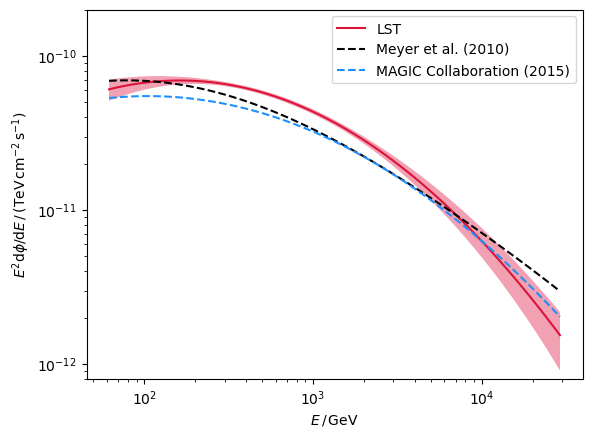

In [15]:
fig, ax = plt.subplots()

plot_kwargs = {
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.GeV,
}

energy_range = [e_min_lst, e_max_lst]

spectral_model.plot(
    energy_range,
    ax=ax,
    color="crimson",
    ls="-",
    label="LST",
    **plot_kwargs,
)
spectral_model.plot_error(
    energy_range, ax=ax, facecolor="crimson", alpha=0.4, **plot_kwargs
)

crab_meyer = create_crab_spectral_model("meyer")
crab_meyer.plot(
    energy_range,
    ax=ax,
    label="Meyer et al. (2010)",
    color="k",
    ls="--",
    **plot_kwargs,
)

crab_magic = create_crab_spectral_model("magic_lp")
crab_magic.plot(
    energy_range,
    ax=ax,
    label="MAGIC Collaboration (2015)",
    color="dodgerblue",
    ls="--",
    **plot_kwargs,
)

ax.legend()

ax.set_xlabel(r"$E\,/\,{\rm GeV}$")
ax.set_ylabel(
    r"$E^2 {\rm d}\phi/{\rm d}E\,/\,({\rm TeV}\,{\rm cm}^{-2}\,{\rm s}^{-1})$"
)
ax.set_ylim([8e-13, 2e-10])
plt.show()

Finally we also compute flux points. Let us use the same binning we have used in estimated energies and select an interval compatible with what used in the likelihood fit.

[Describe what Flux Points are...]

In [16]:
datasets_lst[0].counts.geom.axes["energy"].edges[4:-2]

<Quantity [   63.09573445,   100.        ,   158.48931925,   251.18864315,
             398.10717055,   630.95734448,  1000.        ,  1584.89319246,
            2511.88643151,  3981.07170553,  6309.5734448 , 10000.        ,
           15848.93192461, 25118.8643151 , 39810.71705535] GeV>

In [17]:
energy_edges = datasets_lst[0].counts.geom.axes["energy"].edges[4:-2]
fpe_lst = FluxPointsEstimator(
    energy_edges=energy_edges, source="CrabNebula", selection_optional="all"
)
flux_points_lst = fpe_lst.run(datasets=datasets_lst)

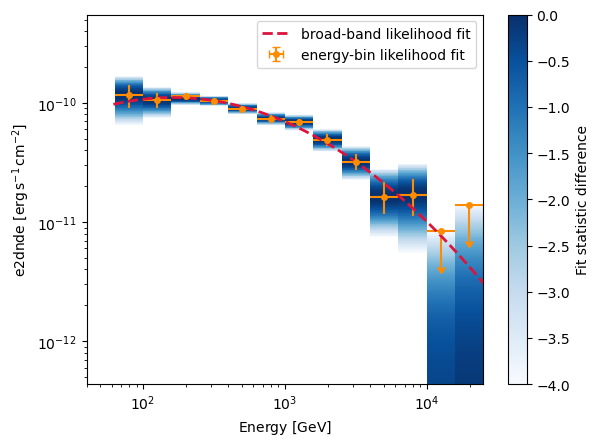

In [18]:
fig, ax = plt.subplots()
flux_points_lst.plot(ax=ax, sed_type="e2dnde", color="darkorange", label="energy-bin likelihood fit")
flux_points_lst.plot_ts_profiles(ax=ax, sed_type="e2dnde")
spectral_model.plot(
    energy_range,
    ax=ax,
    color="crimson",
    ls="--",
    lw=2,
    sed_type="e2dnde",
    label="broad-band likelihood fit"
)
ax.set_xlim([40, 2.5e4])
ax.legend()
plt.show()

# 2.3. Exercises for this tutorial

## Exercise 2.3.
Obtain a multi-instrument measurement of the Crab Nebula spectrum by fitting the datasets from all the instruments at once.   
Compute the flux points for each instrument and overplot them on the final spectrum.

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : 
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 5029747
  Instrument : 
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 5029748
  Instrument : 
  Models     : 

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : 7253
  Instrument : 
  Models     : ['CrabNebula']


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 56
	total stat : 2203.10

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : 

No dataset contribute in range 10.000000000000002 GeV-15.848931924611136 GeV
No dataset contribute in range 15.848931924611136 GeV-25.1188643150958 GeV
No dataset contribute in range 25.1188643150958 GeV-39.810717055349734 GeV
No dataset contribute in range 39.810717055349734 GeV-63.09573444801931 GeV
No dataset contribute in range 63.09573444801931 GeV-100.00000000000004 GeV
No dataset contribute in range 39810.717055349676 GeV-63095.73444801946 GeV
No dataset contribute in range 63095.73444801946 GeV-100000.00000000001 GeV


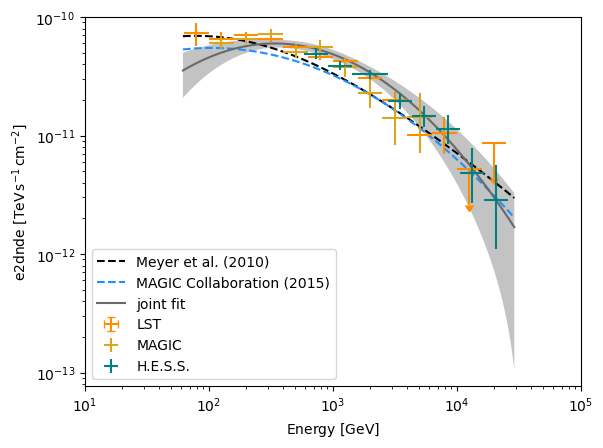

In [19]:
# %load ./solutions/solution_notebook_2.py
# let us perform a spectral measurement using all the data
datasets = Datasets(datasets=[*datasets_hess, *datasets_magic, datasets_lst[0]])
print(datasets)
# apply the model
datasets.model = [model]

# fit
results_joint = fit.run(datasets=datasets)
print(results_joint)
print(model.spectral_model)

# quickly compute spectral points for all the instruments
# - MAGIC
# -- assign the best-fit model to all data sets before computing flux points!
datasets_magic[0].models = [model]
# -- compute them
energy_edges_magic = datasets_magic[0].counts.geom.axes["energy"].edges
fpe_magic = FluxPointsEstimator(
    energy_edges=energy_edges_magic, source="CrabNebula", selection_optional="all"
)
flux_points_magic = fpe_magic.run(datasets=datasets_magic)
# - H.E.S.S.
energy_edges_hess = datasets_hess[0].counts.geom.axes["energy"].edges
# -- assign the best-fit model to all data sets before computing flux points!
datasets_hess[0].models = [model]
# -- compute them
fpe_hess = FluxPointsEstimator(
    energy_edges=energy_edges_hess, source="CrabNebula", selection_optional="all"
)
flux_points_hess = fpe_magic.run(datasets=datasets_hess)


# make a plot
fig, ax = plt.subplots()

# - references first
crab_meyer.plot(
    [e_min_lst, e_max_lst],
    ax=ax,
    label="Meyer et al. (2010)",
    color="k",
    ls="--",
    **plot_kwargs,
)
crab_magic.plot(
    [e_min_lst, e_max_lst],
    ax=ax,
    label="MAGIC Collaboration (2015)",
    color="dodgerblue",
    ls="--",
    **plot_kwargs,
)

# - joint result
spectral_model.plot(
    [e_min_lst, e_max_lst],
    ax=ax,
    color="dimgray",
    ls="-",
    label="joint fit",
    **plot_kwargs,
)
spectral_model.plot_error(
    [e_min_lst, e_max_lst], ax=ax, facecolor="dimgray", alpha=0.4, **plot_kwargs
)

# - flux points of the instruments
flux_points_lst.plot(ax=ax, sed_type="e2dnde", marker=",", color="darkorange", label="LST")
flux_points_magic.plot(ax=ax, sed_type="e2dnde", marker=",", color="goldenrod", label="MAGIC")
flux_points_hess.plot(ax=ax, sed_type="e2dnde", marker=",", color="teal", label="H.E.S.S.")

plt.legend()
plt.show()